In [1]:
import numpy as np
import pandas as pd
from code.load_data import Census_Data_Loader
from code.featurize import Featurize
import os
import us
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 999
import seaborn as sns

/Users/joelshuman/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [40]:
def load_files(featurizer):
    '''Load files from the data directory'''
    # 2012 Election Data
    election_data = pd.read_csv('data/election_2012_cleaned.csv')
    election_data.drop('Unnamed: 0', axis=1, inplace=True)
    # 2013 ACS summary data
    census_data = featurizer.load_summary_cols()
    census_cols = featurizer.load_census_cols()
    # 2013 Population Data
    population = pd.read_csv('data/census_pop.csv')
    # 2013 Citizens of voting age by county
    CVAP = featurizer.load_CVAP()
    # Location of Field offices 2012
    obama_offices = featurizer.load_offices('data/Obama_Office_Locations_Parsed_Cleaned.csv', suffix='dem')
    romney_offices = featurizer.load_offices('data/Romney_Office_Locations_Parsed_Cleaned.csv', suffix='rep')
    # Turnout by state
    total_turnout = featurizer.load_turnout('data/turnout/total_turnout.csv', prefix='tot')
    dem_turnout = featurizer.load_turnout('data/turnout/democratic_turnout.csv', prefix='dem')
    rep_turnout = featurizer.load_turnout('data/turnout/republican_turnout.csv', prefix='rep')
    # More county factors
    education = featurizer.load_education()
    unemployment = featurizer.load_unemployment()
    poverty = featurizer.load_poverty()
    
    return census_data, census_cols, election_data, CVAP, obama_offices, romney_offices, total_turnout, dem_turnout, rep_turnout, education, unemployment, poverty

featurizer = Featurize()
census_data, census_cols, election_data, CVAP, obama_offices, romney_offices, total_turnout, dem_turnout, rep_turnout, education, unemployment, poverty = load_files(featurizer)

In [27]:
def join_cvap_census(census_data, CVAP):
    temp_df = CVAP[CVAP['LNTITLE']=='Total'][['GEONAME', 'CVAP_EST']]
    output = pd.merge(census_data, temp_df, left_on='NAME', right_on='GEONAME', how='left')
    output.loc[output['NAME'] == 'Doña Ana County, New Mexico', 'CVAP_EST'] = 156094 # from census
    output.drop('GEONAME', axis=1, inplace=True)
    return output.fillna(0)

def join_turnout(census_data, turnout):
    output = pd.merge(census_data, turnout, on='state_abbr', how='left')
    return output.fillna(0)

def join_election(census_data, election_data):
    output = pd.merge(census_data, election_data, left_on=['state', 'county'], right_on=['st_num', 'county_num'], how='left')
    output.drop(['st_num', 'county_num'], axis=1, inplace=True)
    return output
    
def join_offices(census_data, office_data):
    office_data['county_id'] = office_data.index.values
    df = pd.merge(census_data, office_data, on='county_id', how='left')
    return df.fillna(0)

def make_joined_df(census_data, CVAP, turnout, election_data, office_data, featurizer, mod_type='dem', k=15, normalize=False):
    temp_df = census_data[['NAME', 'state_abbr', 'state', 'county', 'county_id']]
    temp_df = join_cvap_census(temp_df, CVAP)
    
    turnout_cols = ['2012_p_vote', '2008_delta', '2004_delta', '2000_delta', '1996_delta', '1992_delta']
    turnout_cols = ['state_abbr'] + [mod_type + '_' + x for x in turnout_cols]
    temp_df = join_turnout(temp_df, turnout[turnout_cols])
    
    identifiers = ['st_num', 'county_num']
    education_cols = ['2013 Rural-urban Continuum Code', 
                      'Percent of adults with less than a high school diploma, 2009-2013',
                      'Percent of adults with a high school diploma only, 2009-2013',
                      'Percent of adults with a bachelor\'s degree or higher, 2009-2013']
    temp_df = join_election(temp_df, education[identifiers + education_cols])
    temp_df['Metro Bool'] = temp_df['2013 Rural-urban Continuum Code'].apply(lambda x: x <= 3).astype(int)
    temp_df.drop('2013 Rural-urban Continuum Code', inplace=True, axis=1)
    
    
    unemployment_cols = ['Unemployment_rate_2013']
    temp_df = join_election(temp_df, unemployment[identifiers + unemployment_cols])
    
    poverty_cols = ['PCTPOVALL_2013', 'PCTPOV017_2013']
    temp_df = join_election(temp_df, poverty[identifiers + poverty_cols].apply(pd.to_numeric))
    
    
    temp_census = census_data.drop(['NAME', 'state_full', 'state_abbr', 'county_full', 'county_id', 'state','county'], axis=1)
    # Normalize optional, doesn't help
    if normalize:
        temp_cvap = temp_df[['CVAP_EST']].astype(float)
        temp_census = temp_census.div(temp_cvap['CVAP_EST'], axis=0)
    
    if featurizer.nmf_model is None:
        featurizer.fit_nmf(temp_census.fillna(0), k=k)
    nmf_feats = pd.DataFrame(featurizer.nmf_features)
    nmf_feats.columns = ['nmf_feat_' + str(x) for x in list(nmf_feats.columns)]
    temp_df = temp_df.join(nmf_feats)
    
    temp_df = join_offices(temp_df, office_data)
    temp_df['1_office'] = (temp_df['Num_offices_' + mod_type] == 1).astype(int)
    temp_df['2_office'] = (temp_df['Num_offices_' + mod_type] == 2).astype(int)
    temp_df['more_office'] = (temp_df['Num_offices_' + mod_type] >= 3).astype(int)
    temp_df.drop('Num_offices_' + mod_type, axis=1, inplace=True)
    
    mask = election_data[mod_type] == 1
    mask2 = election_data['st_num'] != 2 # Alaska
    mask3 = election_data['st_num'] != 46 # South Dakota
    temp_df = join_election(temp_df, election_data[mask & mask2 & mask3][['st_num', 'county_num', 'votes']])
    
    return temp_df.fillna(0)

def make_X_y(df, mod_type='dem'):
    X = df.drop(['NAME', 'state_abbr', 'state', 'county', 'county_id', 'votes', mod_type + '_2012_p_vote'], axis=1)
    cols = X.columns
    perc_vote = df['votes'] / df['CVAP_EST'].astype(float)
    y = perc_vote
    #y = 100. * perc_vote - df[mod_type + '_2012_p_vote'].astype(float)
    #y = df['votes']
    return X, y.values, cols

In [28]:
obama_df = make_joined_df(census_data, CVAP, dem_turnout, election_data, obama_offices, featurizer, mod_type='dem', k=5, normalize=False)
romney_df = make_joined_df(census_data, CVAP, rep_turnout, election_data, romney_offices, featurizer, mod_type='rep', k=5, normalize=False)

In [29]:
X_obama, y_obama, feat_names_obama = make_X_y(obama_df, mod_type='dem')
X_romney, y_romney, feat_names_romney = make_X_y(romney_df, mod_type='rep')

In [30]:
# ols = sm.OLS(y_obama, sm.add_constant(X_obama)).fit()

glsar_model = sm.GLSAR(y_obama, X_obama, rho=1)
glsar_results = glsar_model.iterative_fit(1)
print glsar_results.condition_number
print len(str(int(glsar_results.condition_number)))
glsar_results.summary()

36177310.4364
8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.914
Model:                          GLSAR   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1530.
Date:                Tue, 29 Dec 2015   Prob (F-statistic):               0.00
Time:                        15:31:06   Log-Likelihood:                 3648.1
No. Observations:                3047   AIC:                            -7254.
Df Residuals:                    3026   BIC:                            -7128.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------------------
CVAP_EST                                                          -1.507e-07    5.1e-08     -2.959      0.003     -2.51e-07 -5.08e-08
dem_2008_delta                                                        0.0080      0.001      8.327      0.000         0.006     0.010
dem_2004_delta                                                       -0.0129      0.001    -11.642      0.000        -0.015    -0.011
dem_2000_delta                                                        0.0052      0.001      4.121      0.000         0.003     0.008
dem_1996_delta                                                       -0.0010      0.001     -0.880      0.379        -0.003     0.001
dem_1992_delta                                                        0.0097      0.001     10.095      0.000         0.008     0.012
Percent of adults with less than a high school diploma, 2009-2013    -0.0014      0.000     -4.903      0.000        -0.002    -0.001
Percent of adults with a high school diploma only, 2009-2013          0.0002      0.000      1.345      0.179     -9.08e-05     0.000
Percent of adults with a bachelor's degree or higher, 2009-2013       0.0049      0.000     28.649      0.000         0.005     0.005
Metro Bool                                                            0.0052      0.003      1.590      0.112        -0.001     0.012
Unemployment_rate_2013                                                0.0081      0.001     11.077      0.000         0.007     0.009
PCTPOVALL_2013                                                        0.0009      0.001      1.464      0.143        -0.000     0.002
PCTPOV017_2013                                                        0.0021      0.000      4.499      0.000         0.001     0.003
nmf_feat_0                                                            0.4333      0.143      3.025      0.003         0.152     0.714
nmf_feat_1                                                            0.1294      0.047      2.774      0.006         0.038     0.221
nmf_feat_2                                                            0.1085      0.044      2.457      0.014         0.022     0.195
nmf_feat_3                                                            0.2537      0.059      4.287      0.000         0.138     0.370
nmf_feat_4                                                            0.5686      0.167      3.401      0.001         0.241     0.896
1_office                                                              0.0295      0.005      5.930      0.000         0.020     0.039
2_office                                                              0.0387      0.010      3.878      0.000         0.019     0.058
m

In [6]:
def print_fi(model, feature_names, featurizer, num_print=10, prints_on=False, plots_on=False):
    idx_imp_feat = np.argsort(model.feature_importances_)[::-1]
    imp = model.feature_importances_ / max(model.feature_importances_)
    if prints_on:
        for x, y in zip(feature_names[idx_imp_feat[:num_print]], imp[idx_imp_feat[:num_print]]):
            print 'Feature: %s, Importance: %s' % (featurizer.get_col_desc(x), y)
    if plots_on:
        plt.bar(left=range(int(num_print)), 
                height=imp[idx_imp_feat[:num_print]])
        plt.xlabel('Features')
        plt.ylabel('Importances')
        plt.title('Feature Importances, scaled')
        plt.xticks(range(int(num_print)), feature_names[idx_imp_feat[:num_print]], rotation=90)

In [7]:
def get_kfold(model, X, y):
    kf = KFold(X.shape[0], n_folds=5, shuffle=True)
    r2, mse = [], []
    for train_index, test_index in kf:
        model.fit(X[train_index], y[train_index])
        y_pred = model.predict(X[test_index])
        r2.append(r2_score(y[test_index], y_pred))
        mse.append(mean_squared_error(y[test_index], y_pred))
    
    print 'Model: %s, R2: %s, MSE: %s' % (model.__class__.__name__, np.mean(r2), np.mean(mse))

In [76]:
rf = RandomForestRegressor(n_estimators=25, max_depth=3)
lr = LinearRegression()
ridge = Ridge(alpha=.01, normalize=True)
lasso = Lasso(alpha=.01, normalize=True)
svr = SVR(C=1, degree=5)
gb = GradientBoostingRegressor()


In [123]:
models = [rf, lr, ridge, lasso, svr, gb]
for model in models:
    get_kfold(model, X_romney.values, y_romney)

Model: RandomForestRegressor, R2: 0.395852311542, MSE: 0.00575256262953
Model: LinearRegression, R2: 0.412454148069, MSE: 0.00556016017769
Model: Ridge, R2: 0.406323091025, MSE: 0.00564580401311
Model: Lasso, R2: -0.00502521572061, MSE: 0.00953674417683
Model: SVR, R2: -0.0154577915103, MSE: 0.00961018321929
Model: GradientBoostingRegressor, R2: 0.624882536241, MSE: 0.00356651493463


In [84]:
for x, y in zip(ridge.coef_, feat_names_romney):
    print y, x

CVAP_EST -2.3002486914e-08
rep_2004_delta 0.00386398485994
rep_2000_delta -0.0063308837016
rep_1996_delta 0.00978117343315
rep_1992_delta -0.00122451531305
Percent of adults with less than a high school diploma, 2009-2013 0.000324319843378
Percent of adults with a high school diploma only, 2009-2013 0.000581306335895
Percent of adults completing some college or associate's degree, 2009-2013 0.00306138981743
Percent of adults with a bachelor's degree or higher, 2009-2013 -0.00158693882975
Metro Bool -0.0249107471578
Median_Household_Income_Percent_of_State_Total_2013 0.00090788271216
Unemployment_rate_2013 -0.00751293777552
PCTPOVALL_2013 -0.0086004848871
PCTPOV017_2013 0.00318571897944
nmf_feat_0 0.0312120745237
nmf_feat_1 -0.0494620585383
nmf_feat_2 -0.143060398071
nmf_feat_3 -0.0847522472652
nmf_feat_4 -0.214689376786
1_office -0.000221144337502
2_office 0.00707091113773
3_office 0.00778021041674
more_office 0.0178040230125


In [85]:
print_fi(rf, feat_names_obama, featurizer, prints_on=True)

Feature: CVAP_EST, Importance: 1.0
Feature: PCTPOVALL_2013, Importance: 0.609544504608
Feature: nmf_feat_1, Importance: 0.299074984862
Feature: Unemployment_rate_2013, Importance: 0.148960393467
Feature: nmf_feat_4, Importance: 0.0981657580566
Feature: dem_1992_delta, Importance: 0.0748184477103
Feature: dem_2004_delta, Importance: 0.0513717015308
Feature: dem_1996_delta, Importance: 0.0471242201244
Feature: Median_Household_Income_Percent_of_State_Total_2013, Importance: 0.0468437963255
Feature: Percent of adults with a high school diploma only, 2009-2013, Importance: 0.0433457457427


In [108]:
X_obama_counter, y_obama, feat_names_obama = make_X_y(obama_df.drop(['1_office', '2_office', 'more_office'], axis=1), mod_type='dem')
lr_count = LinearRegression().fit(X_obama_counter, y_obama)
lr_norm = LinearRegression().fit(X_obama, y_obama)

has_1_offices = X_obama['1_office'].values == 1
has_2_offices = X_obama['2_office'].values == 1
has_more_offices = X_obama['more_office'].values == 1

votes_counter_1 = lr_count.predict(X_obama_counter[has_1_offices])
votes_counter_2 = lr_count.predict(X_obama_counter[has_2_offices])
votes_counter_more = lr_count.predict(X_obama_counter[has_more_offices])
votes_norm_1 = lr_norm.predict(X_obama[has_1_offices])
votes_norm_2 = lr_norm.predict(X_obama[has_2_offices])
votes_norm_more = lr_norm.predict(X_obama[has_more_offices])

num_votes_counter_1 = sum(votes_counter_1 * obama_df[has_1_offices]['CVAP_EST'].values)
num_votes_counter_2 = sum(votes_counter_2 * obama_df[has_2_offices]['CVAP_EST'].values)
num_votes_counter_more = sum(votes_counter_more * obama_df[has_more_offices]['CVAP_EST'].values)

num_votes_norm_1 = sum(votes_norm_1 * obama_df[has_1_offices]['CVAP_EST'].values)
num_votes_norm_2 = sum(votes_norm_2 * obama_df[has_2_offices]['CVAP_EST'].values)
num_votes_norm_more = sum(votes_norm_more * obama_df[has_more_offices]['CVAP_EST'].values)

print 'Normal, Counterfactual, Difference, CVAP'
print '1', num_votes_norm_1, num_votes_counter_1, num_votes_norm_1 - num_votes_counter_1, np.sum(obama_df[has_1_offices]['CVAP_EST'].values)
print '2', num_votes_norm_2, num_votes_counter_2, num_votes_norm_2 - num_votes_counter_2, np.sum(obama_df[has_2_offices]['CVAP_EST'].values)
print 'more', num_votes_norm_more, num_votes_counter_more, num_votes_norm_more - num_votes_counter_more, np.sum(obama_df[has_more_offices]['CVAP_EST'].values)
print sum([num_votes_norm_1 - num_votes_counter_1, num_votes_norm_2 - num_votes_counter_2, num_votes_norm_more - num_votes_counter_more])

# print "Normal: %s, Counter: %s, Difference: %s" % (num_votes_norm, num_votes_counter, (num_votes_norm-num_votes_counter))
# 3% of total votes (1.9M of 62M)

Normal, Counterfactual, Difference, CVAP
1 17985847.8459 17520095.3271 465752.51879 54072070.0
2 5717174.42829 5621758.25648 95416.1718062 14661669.0
more 13690213.7267 13279560.8657 410652.860953 35164090.0
971821.551549


In [33]:
def plot_hist(X, col, y_same, y_diff, c='b'):
    if c == 'b':
        c2 = 'r'
    else: c2 = 'b'
    mask = y_same >= y_diff
    not_mask = y_same < y_diff
    vote_for = X[mask].copy()
    vote_against = X[not_mask]
    vote_for[col].hist(color=c, label='For Candidate', alpha=.3)
    vote_against[col].hist(color=c2, label='Against Candidate', alpha=.3)
    plt.title('Histogram of %s' % col)
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.legend()
    plt.show()
    
def plot_scatter(df, col, y):
    x = df[col]
    plt.scatter(x, y, alpha=.4)
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))
    plt.xlabel(col)
    plt.ylabel('County Vote Share')
    plt.title('%s versus Percent of vote' % col)
    print 'Slope = %s' % slope
    plt.show()


Slope = 2.93587811631e-09


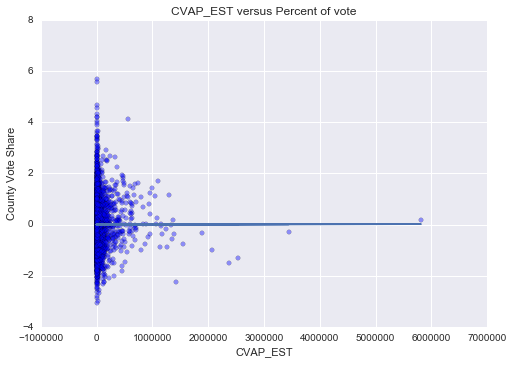

Slope = -0.00179592762081


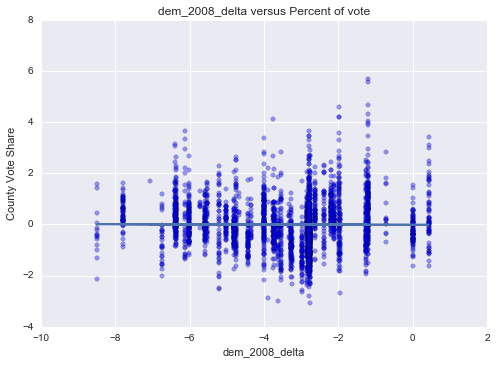

Slope = 4.09011088622e-05


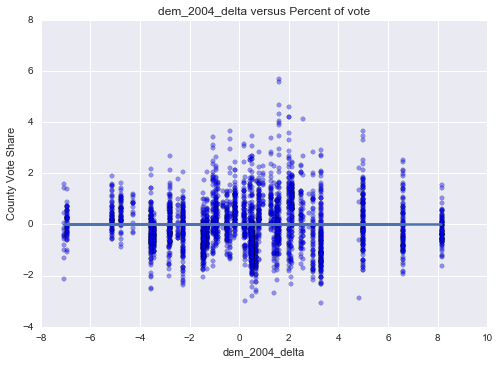

Slope = 0.000365591363748


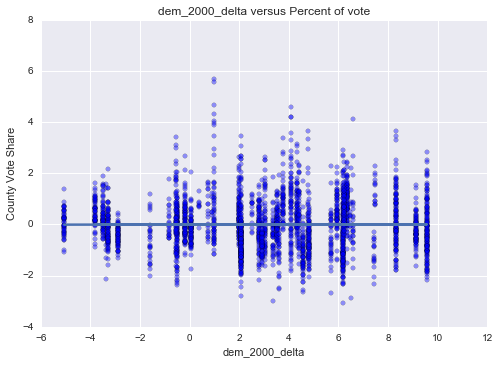

Slope = 0.000223320255759


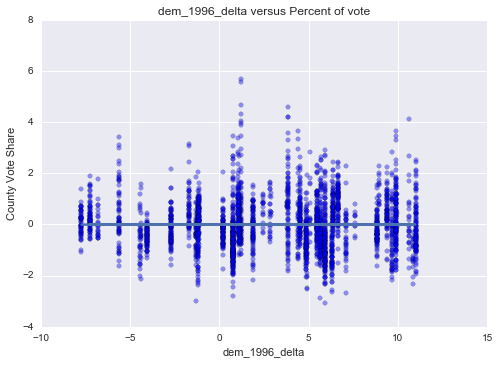

Slope = 0.000194411378325


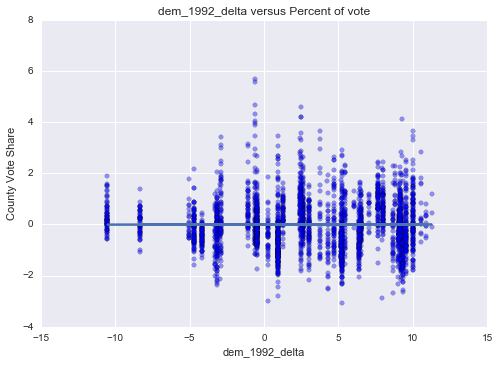

Slope = 0.000551956283208


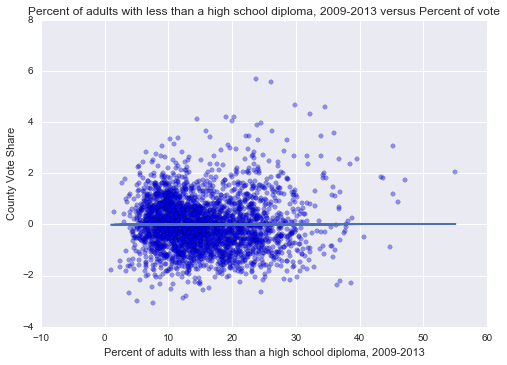

Slope = 0.00119694497077


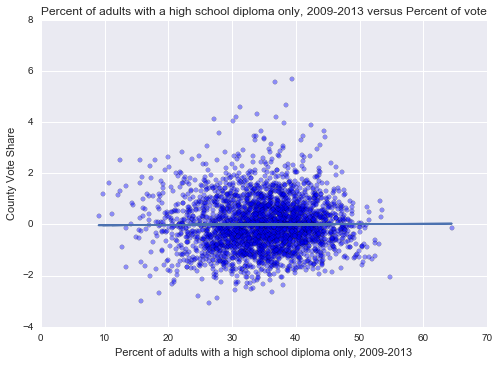

Slope = 0.000425908239877


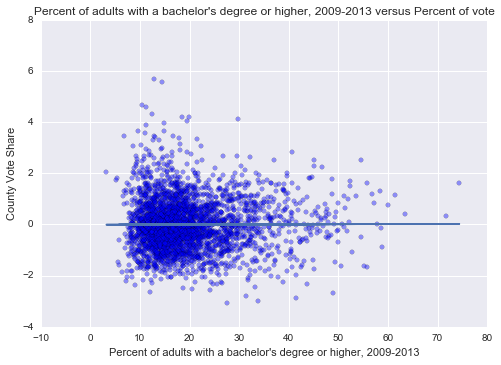

Slope = 0.00267560950086


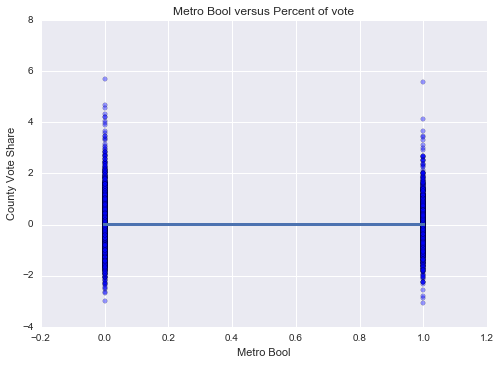

Slope = 0.00187074416869


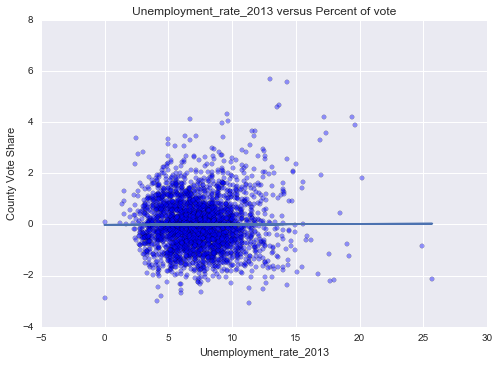

Slope = 0.000700341932323


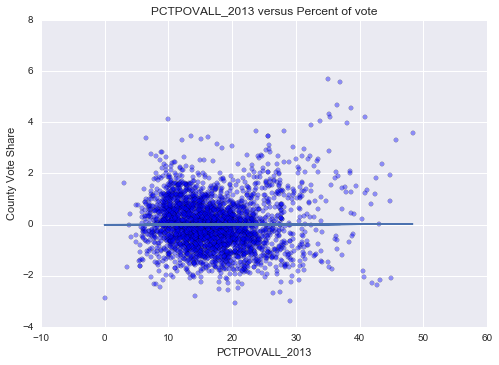

Slope = 0.00046850984161


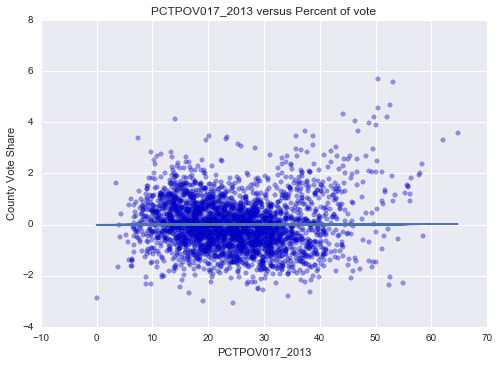

Slope = 0.00266287763861


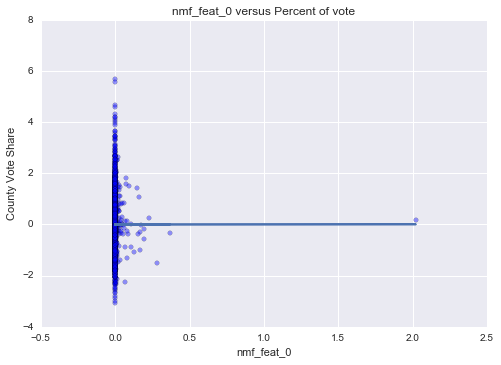

Slope = 0.00214336664083


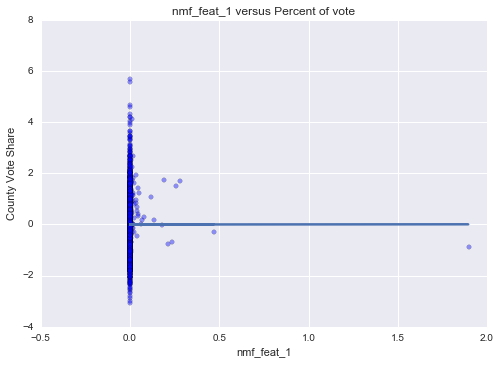

Slope = 0.00368725789401


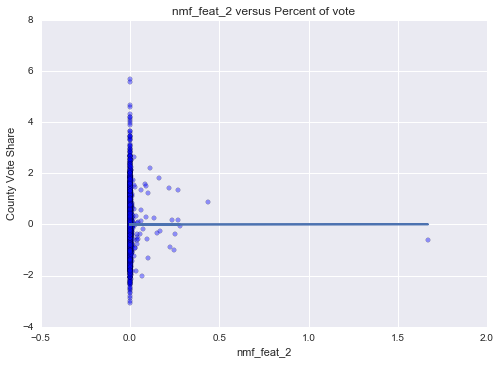

Slope = 0.00332557440475


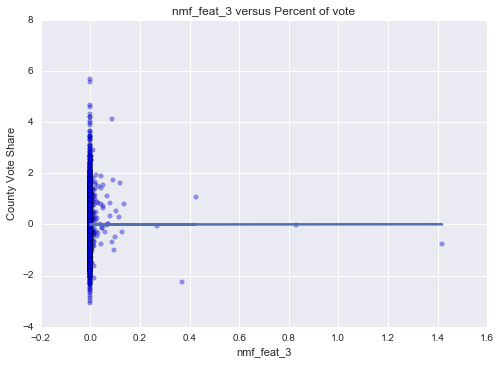

Slope = 0.0156923847301


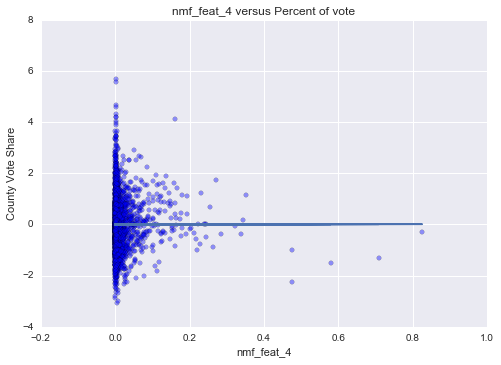

Slope = 0.00192910159949


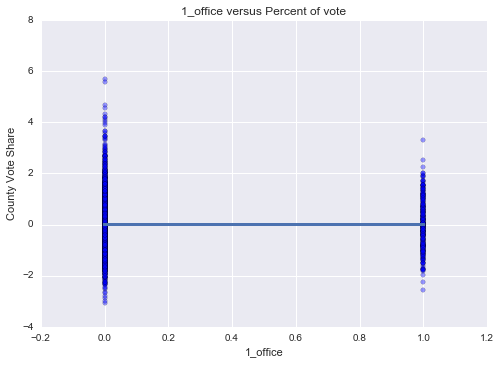

Slope = 0.00176242101922


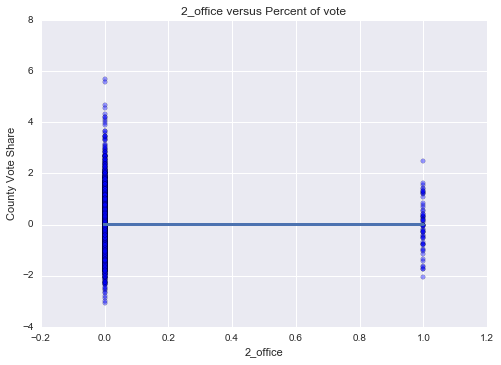

Slope = 0.00176183098874


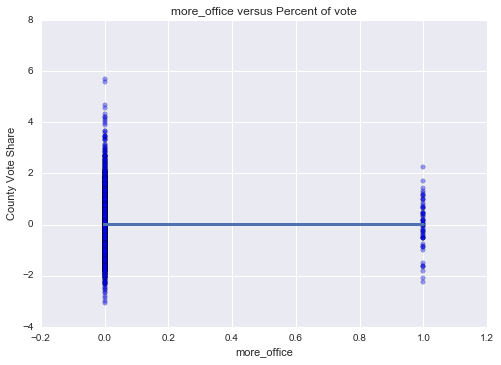

In [34]:
for feat in feat_names_obama:
    plot_scatter(obama_df, feat, s_resid)

In [2]:
s_resid = glsar_results.resid / np.std(glsar_results.resid)
plt.scatter(y_obama, s_resid)
plt.xlabel('Vote Turnout')
plt.title('Studentized Residuals')
plt.ylabel('Residuals')

NameError: name 'glsar_results' is not defined

In [45]:
featurizer.census_cols

,name,label
0,AIANHH,Selectable Geographies: FIPS AIANHH code
1,AIHHTLI,Selectable Geographies: American Indian Trust ...
2,AITS,Selectable Geographies: American Indian Tribal...
3,AITSCE,Selectable Geographies: American Indian Tribal...
4,ANRC,Selectable Geographies: Alaska Native Regional...
5,B00001_001E,B00001. Unweighted Sample Count of the Popula...
6,B00001_001M,B00001. Unweighted Sample Count of the Popula...
7,B00002_001E,B00002. Unweighted Sample Housing Units: Total
8,B00002_001M,B00002. Unweighted Sample Housing Units: Marg...
9,B01001A_001E,B01001A. SEX BY AGE (WHITE ALONE): Total:


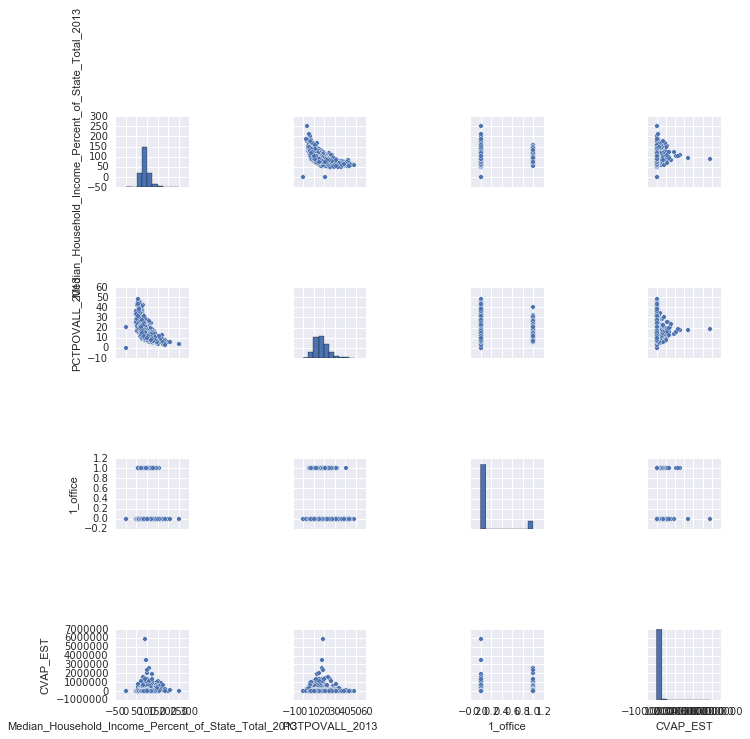

In [115]:
sns.pairplot(obama_df[['Median_Household_Income_Percent_of_State_Total_2013', 
                       'PCTPOVALL_2013', 
                       ,
                       ]])

In [28]:
import plotly.plotly as py
import plotly.graph_objs as go

def get_plotly_vars(df, obama_target, romney_target):
    red = 'rgb(255, 65, 54)'
    blue = 'rgb(93, 164, 214)'
    winner = df['votes_Obama'] - df['votes_Romney']
    votes_cast = df['votes_Obama'] + df['votes_Romney']
    close_calls = []
    for x in xrange(winner.shape[0]):
        if np.abs(winner[x] / float(votes_cast[x])) < .05:
            close_calls.append(1)
        else:
            close_calls.append(.3)
    color = []
    for x in winner:
        if x > 0:
            color.append(blue)
        else:
            color.append(red)

    text = []
    for idx in xrange(df.shape[0]):
        name = df.iloc[idx]['State_Stripped']
        pop = df.iloc[idx]['P0010001']
        ob_v = np.round(df.iloc[idx]['votes_Obama'] / float(pop), 3) * 100
        ro_v = np.round(df.iloc[idx]['votes_Romney'] / float(pop), 3) * 100
        vote_cast = votes_cast[idx]
        temp = 'State: %s<br>Votes Cast: %s<br>Obama Vote: %s<br>Romney Vote: %s' %(name, vote_cast, str(ob_v)+'%', str(ro_v)+'%')
        text.append(temp)
    return color, close_calls, np.log(votes_cast), text


In [29]:
#color, close_calls, size, text = get_plotly_vars(census_elect_office, obama_target, romney_target)
color, close_calls, size, text = get_plotly_vars(state_elect_office, state_obama_target, state_romney_target)

In [31]:
#Probably better to do this by state
trace0 = go.Scatter(
    x=state_obama_target,
    y=state_romney_target,
    mode='markers',
    text = text,
    marker=dict(
        color=color,
        opacity=close_calls,
        size=size
    )
)
data = [trace0]
layout = go.Layout(
    title='County Results and Populations',
    xaxis=dict(
        range=[0,1],
        title='% Obama Vote',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        range=[0,1],
        title='% Romney Vote',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='bubblechart-color')

In [ ]:
featu